## Transfer Learning



Instead of using directly the frames of the image, you will extract the image features from the pre-trained network VGG.

And then add our customized classifier layer to classify images using the features

### Import Necessary Libraries

In [ ]:
import keras
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.layers import Flatten
from keras.layers import Dense
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Load the dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/Computer_Vision/DataSet/Dataset.zip .
!unzip Dataset.zip -d dataset

Calculate the number of images

In [ ]:
def get_images_number(path_to_images):
  number = []
  paths_list = sorted(glob.glob(path_to_images + "/*"))
  for label in paths_list:
    number.append(len(glob.glob(label + "/*")))
  return number

In [ ]:
path_to_images = "/content/dataset"
images_number = get_images_number(path_to_images)
sum(images_number)

3042

Load data

In [ ]:
def load_data(number_letters, path_to_images):
  # get the numbers of each label
  images_number = get_images_number(path_to_images)
  # create samples array
  samples = np.empty((sum(images_number), 32, 32, 3))
  letters = []
  index = 0
  for folder in sorted(glob.glob(path_to_images+'/*')):
    label = folder.split('/')[3]
    # convert label from str to int
    label = ord(label)-ord('A')
    
    for image_path in sorted(glob.glob(folder+"/*")):
      # load the image
      img = image.load_img(image_path)
      # convert the image into array
      img = image.img_to_array(img)
      # convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.
      img = preprocess_input(img)
      # save the solved img 
      samples[index] = img
      index += 1
      letters.append(label)
  return samples, np.array(letters)

In [ ]:
samples, letters = load_data(images_number, path_to_images)

Split the dataset

In [ ]:
# split dataset into Train, Test, and Validation
X_train, X_test, y_train, y_test = train_test_split(
  samples, letters, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
  X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_val.shape[0], 'val samples')

2189 train samples
305 test samples
548 val samples


Plot some images

those images have been zero-center each color channel with respect to the ImageNet dataset, without scaling.

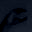

In [ ]:
cv2_imshow(X_train[100])

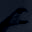

In [ ]:
cv2_imshow(X_test[1])

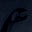

In [ ]:
cv2_imshow(X_val[1])

In [ ]:
X_train[0].shape

(32, 32, 3)

### Build the basic model


In [ ]:
input_shape = X_train[0].shape
vgg_model = VGG19(include_top=False,input_shape=input_shape, weights='imagenet') # Load VGG model and weights

In [ ]:
vgg_model.input.shape 

TensorShape([None, 32, 32, 3])

In [ ]:
vgg_model.output

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

not change the frozen layer weights

In [ ]:
# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False

using vgg to extract the images features

In [ ]:
output_feats = vgg_model.predict(X_test)

In [ ]:
output_feats[0]

array([[[ 0.       ,  0.       ,  0.       ,  0.       ,  1.4489092,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       , 10.604821 ,  0.       ,  0.       ,  2.6875823,
          0.       , 31.02271  ,  2.571641 ,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       , 26.347258 ,
          0.       ,  0.       ,  7.2369356,  0.       ,  0.       ,
          0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ,  0.       ,  4.4908605,  0.       ,  0.       ,
          3.3679817,  0.       ,  3.0042799, 24.773682 ,  0.       ,
          0.       ,  8.522136 , 21.77106  ,  0.       ,  0.       ,
          0.       ,  0.       , 17.049944 ,  0.       ,  6.716171 ,
         30.381544 ,  0.       ,  

In [ ]:
output_feats.shape

(305, 1, 1, 512)

### Build the model adding classified layer


In [ ]:
vgg_model.output

<KerasTensor: shape=(None, 1, 1, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
# add new classifier layers
flat1 = Flatten()(vgg_model.output)
fc1 = Dense(1024, activation='relu')(flat1)
# activation = "sigmoid" -> multiple labels
output = Dense(3, activation='softmax')(fc1)
output

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'dense_7')>

In [ ]:
classified_model = Model(inputs=vgg_model.input, outputs=output) 

In [ ]:
classified_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

#### Compile the model and train the model

In [ ]:
classified_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Change the shape of labels to fit the output layer size

In [ ]:
num_classes = 3
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [ ]:
y_train.shape

(2189, 3)

In [ ]:
y_train[0]

array([0., 0., 1.], dtype=float32)

Train the model

In [ ]:
epochs =5
history = classified_model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val)
                    )

Epoch 1/5
69/69 [==============================] - 22s 317ms/step - loss: 1.4030 - accuracy: 0.8148 - val_loss: 0.0340 - val_accuracy: 0.9909
Epoch 2/5
69/69 [==============================] - 22s 314ms/step - loss: 0.0361 - accuracy: 0.9914 - val_loss: 0.0835 - val_accuracy: 0.9872
Epoch 3/5
69/69 [==============================] - 22s 315ms/step - loss: 0.0225 - accuracy: 0.9919 - val_loss: 0.0259 - val_accuracy: 0.9945
Epoch 4/5
69/69 [==============================] - 22s 315ms/step - loss: 0.0253 - accuracy: 0.9935 - val_loss: 0.1299 - val_accuracy: 0.9799
Epoch 5/5
69/69 [==============================] - 22s 316ms/step - loss: 0.0184 - accuracy: 0.9957 - val_loss: 0.0407 - val_accuracy: 0.9891


In [ ]:
score = classified_model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.0407368466258049
Validation accuracy: 0.989051103591919


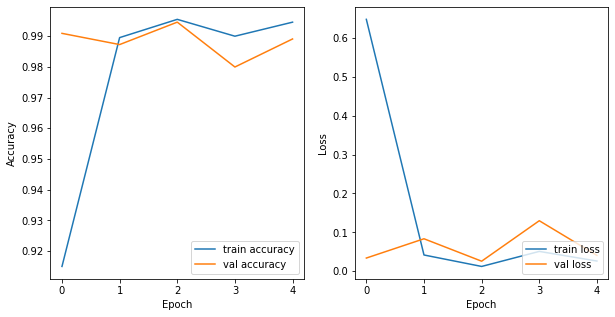

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### Prediction

In [ ]:
prediction = classified_model.predict(X_test)

In [ ]:
y_pred = [x.argmax() for x in prediction]
confusion_matrix(y_test, y_pred)

array([[115,   0,   0],
       [  1,  92,   0],
       [  1,   0,  96]])

In [ ]:
prediction[1]

array([1.3633745e-12, 1.1782034e-10, 1.0000000e+00], dtype=float32)

In [ ]:
X_val[0:3].shape

(3, 32, 32, 3)

In [ ]:
new_output = np.array([[1,1,0],
                        [1,1,1],
                        [1,0,1]])

In [ ]:
new_output.shape

(3, 3)

In [ ]:
classified_model.fit(X_val[0:3], new_output)

1/1 [==============================] - 1s 655ms/step - loss: 4.8765 - accuracy: 0.3333


In [ ]:
pred = classified_model.predict(X_val[0:3])

In [ ]:
pred[0]

array([0.9999273 , 1.        , 0.16636792], dtype=float32)